In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm
import dill as pickle
import statsmodels

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

<ipython-input-1-1e75e9e9177d>:23: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
final_data = pd.read_pickle("tmp/final_data.pkl")

results_states = pickle.load(open('tmp/trained_models_states.pkl', 'rb'))

descriptive_stats = pd.read_pickle("tmp/residual_descriptive_stats.pkl")


## White noise

In [3]:
np.random.seed(123)
dates = pd.date_range(final_data[["Updated"]].min().values[0], final_data[["Updated"]].max().values[0]).values
u0 = np.random.normal(size=len(dates))

u0 = pd.DataFrame({"Updated": dates, "Residual": u0})
u0.head()

,Updated,Residual
0,2020-02-28,-1.085631
1,2020-02-29,0.997345
2,2020-03-01,0.282978
3,2020-03-02,-1.506295
4,2020-03-03,-0.578600


<AxesSubplot:>

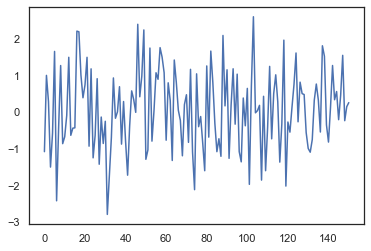

In [4]:
u0["Residual"].plot()

In [5]:
u0.to_pickle("tmp/u0.pkl")

## $h_.(t)$ linear filters

In [6]:
from functools import partial

In [7]:
# Check the value of lag (p) used in the Yule-Walker method through the AIC
# http://pages.stern.nyu.edu/~churvich/TimeSeries/Handouts/AICC.pdf
# page 2, formula 1

# AIC = n*(log(sigma^2) + 1) + 2*(p + 1)*n/(n-p-2)

AIC_table = pd.DataFrame(columns=descriptive_stats.state)

def yule_walker_aic():
    '''
    The idea is to iterate through the 17 US states
    and for each state's GP residual, compute the AIC value for the Yule-Walker model for lags from 1-5
    as an extra step we also compute the AIC value according to the recommended lag by the ACF model in        MO-1 (descriptive_stats::lags small)
    '''

    for state in results_states.keys():
        state_residual = results_states[state][1]
        n = len(state_residual)
        AIC = []

        # First method, use the ACF results (lags small) from MO - 1. Table 'descriptive_stats'
        ORDER = int(descriptive_stats[descriptive_stats.state == state]["lags small"])
        rho_, sigma_ = sm.regression.yule_walker(state_residual, order=ORDER, method="mle")
        p = len(rho_)
        AIC_i = np.round(n*(np.log(sigma_**2) + 1) + 2*(p + 1)*n/(n-p-2), 2)
        AIC.append(AIC_i)

        # Second method, fine tune the AIC for a series of lags
        for ORDER in range(5): 
            ORDER = ORDER + 1
            rho_, sigma_ = sm.regression.yule_walker(state_residual, order=ORDER, method="mle")
            p = len(rho_)
            AIC_i = np.round(n*(np.log(sigma_**2) + 1) + 2*(p + 1)*n/(n-p-2), 2)
            AIC.append(AIC_i)
  
        # Add the AIC results for each lag to the state column
        AIC_table[state] = AIC


In [8]:
# Run the script
# The table below shows the AIC for each lag by state
# 1st row is the lag as defined in descriptive_stats::lags small
# the subsequent rows show the AIC for lags 1-5
yule_walker_aic()
AIC_table

state,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas
0,-484.77,-476.90,-471.43,-419.33,-522.30,-451.56,-449.31,-469.44,-570.49,-485.35,-496.24,-353.81,-418.70,-545.04,-569.57,-495.19,-531.93
1,-474.31,-475.58,-473.66,-419.44,-531.20,-442.85,-443.98,-470.40,-568.92,-484.59,-498.18,-353.81,-418.70,-539.51,-578.50,-490.94,-531.18
2,-474.28,-473.75,-473.00,-417.39,-529.36,-451.19,-442.90,-470.46,-568.24,-484.99,-496.24,-356.78,-425.15,-544.97,-576.93,-499.07,-530.23
3,-473.99,-477.89,-470.96,-422.65,-528.68,-453.68,-442.98,-469.77,-572.48,-482.95,-499.05,-354.82,-423.05,-547.15,-575.39,-497.13,-531.93
4,-481.18,-475.79,-468.94,-420.95,-527.02,-451.56,-446.55,-469.93,-570.49,-485.35,-496.91,-355.50,-420.99,-545.04,-573.25,-495.19,-531.85
5,-479.11,-476.90,-472.21,-419.33,-525.17,-461.44,-447.87,-468.12,-573.36,-486.68,-494.80,-353.33,-419.53,-548.50,-571.28,-503.82,-530.34


In [9]:
descriptive_stats

,state,min date,max date,count,ADF p-value,lags,ADF p-value small,lags small,min values,max values,mean,median,sd,optimal lag,AIC diff
0,Alabama,2020-02-28,2020-07-27,151,0.001,21,0.0,7,-0.436368,0.490748,0.000093,0.001422,0.166738,7,10.78
1,Alaska,2020-02-28,2020-07-27,151,0.000,0,0.0,5,-0.575354,0.344012,0.000478,-0.006051,0.153685,3,4.14
2,Arizona,2020-02-28,2020-07-27,151,0.000,9,0.0,0,-0.522762,0.497143,-0.000081,0.002783,0.126892,1,4.72
3,Arkansas,2020-02-28,2020-07-27,151,0.000,5,0.0,5,-0.617740,0.529385,-0.000016,0.004379,0.162828,3,5.26
4,California,2020-02-28,2020-07-27,151,0.000,6,0.0,7,-0.443048,0.553555,0.000022,0.004882,0.114899,1,8.90
5,Colorado,2020-02-28,2020-07-27,151,0.000,0,0.0,4,-1.224421,0.487439,0.000012,0.009615,0.164364,5,18.59
6,Connecticut,2020-02-28,2020-07-27,151,0.000,5,0.0,6,-0.674588,0.331076,-0.000007,0.016808,0.150060,6,6.41
7,Delaware,2020-02-28,2020-07-27,151,0.000,17,0.0,6,-0.481264,0.506871,0.000297,0.015521,0.176996,2,2.34
8,District of Columbia,2020-02-28,2020-07-27,151,0.000,6,0.0,4,-0.274038,0.251222,-0.000049,-0.006508,0.094845,5,5.12
9,Florida,2020-02-28,2020-07-27,151,0.000,16,0.0,4,-0.606273,0.504574,0.000016,-0.000222,0.129317,5,3.73


In [10]:
# Add to the descriptive stats table the optimimum lag for each state
descriptive_stats["optimal lag"] = 0
descriptive_stats["AIC diff"] = 0

for state in results_states.keys():
    lag_value = AIC_table[state].idxmin()
    AIC_diff = AIC_table[state].max() - AIC_table[state].min()
    if lag_value==0:
        lag_value = int(descriptive_stats.loc[descriptive_stats.state==state]["lags small"])

    descriptive_stats.loc[descriptive_stats.state==state, "optimal lag"] = lag_value
    descriptive_stats.loc[descriptive_stats.state==state, "AIC diff"] = AIC_diff


In [11]:
descriptive_stats

,state,min date,max date,count,ADF p-value,lags,ADF p-value small,lags small,min values,max values,mean,median,sd,optimal lag,AIC diff
0,Alabama,2020-02-28,2020-07-27,151,0.001,21,0.0,7,-0.436368,0.490748,0.000093,0.001422,0.166738,7,10.78
1,Alaska,2020-02-28,2020-07-27,151,0.000,0,0.0,5,-0.575354,0.344012,0.000478,-0.006051,0.153685,3,4.14
2,Arizona,2020-02-28,2020-07-27,151,0.000,9,0.0,0,-0.522762,0.497143,-0.000081,0.002783,0.126892,1,4.72
3,Arkansas,2020-02-28,2020-07-27,151,0.000,5,0.0,5,-0.617740,0.529385,-0.000016,0.004379,0.162828,3,5.26
4,California,2020-02-28,2020-07-27,151,0.000,6,0.0,7,-0.443048,0.553555,0.000022,0.004882,0.114899,1,8.90
5,Colorado,2020-02-28,2020-07-27,151,0.000,0,0.0,4,-1.224421,0.487439,0.000012,0.009615,0.164364,5,18.59
6,Connecticut,2020-02-28,2020-07-27,151,0.000,5,0.0,6,-0.674588,0.331076,-0.000007,0.016808,0.150060,6,6.41
7,Delaware,2020-02-28,2020-07-27,151,0.000,17,0.0,6,-0.481264,0.506871,0.000297,0.015521,0.176996,2,2.34
8,District of Columbia,2020-02-28,2020-07-27,151,0.000,6,0.0,4,-0.274038,0.251222,-0.000049,-0.006508,0.094845,5,5.12
9,Florida,2020-02-28,2020-07-27,151,0.000,16,0.0,4,-0.606273,0.504574,0.000016,-0.000222,0.129317,5,3.73


In [12]:
descriptive_stats.to_pickle("tmp/residual_descriptive_stats.pkl")

In [13]:
# In case we want to revert back to the original method of shared lags across states
# Don't forget to uncomment the ORDER and revert the yule_walker order
linear_filters_states = {}

# ORDER = 5

for state in results_states.keys():
    ORDER = int(descriptive_stats.loc[descriptive_stats.state==state, "optimal lag"])
    u0_ = u0[u0['Updated'].isin(final_data.loc[state, 'Updated'])]
    state_residual = results_states[state][1]
    t = u0_["Updated"].index.astype('float').values.reshape(-1, 1)

    def _yule_walker(u=None, coeff_=None, sigma_=None):
        return np.convolve(coeff_, u, mode="same")

    rho_, sigma_ = sm.regression.yule_walker(state_residual, order=ORDER, method="mle")
    rho_ = np.array(rho_)[::-1]
    linear_filters_states[state] = rho_, partial(
        _yule_walker, u=u0_["Residual"].values, coeff_=tuple(rho_), sigma_=sigma_
    )
        

pickle.dump(linear_filters_states, open('tmp/linear_filters_states.pkl', 'wb'))